# Notebook for [Pytorch Dataloader for Image GT dataset](https://stackoverflow.com/questions/59467781/pytorch-dataloader-for-image-gt-dataset)

<!--<badge>--><a href="https://colab.research.google.com/github/trsvchn/stackoverflow-notebooks/blob/master/custom-vision-dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><!--</badge>-->

In [1]:
%matplotlib inline

We need some data with particular structure consisting of 2 folders: RGB and GT.

In [2]:
import os
import numpy as np
from PIL import Image
from PIL import ImageDraw 


root = './origin_test_image'
rgb = os.path.join(root, 'VIS')
gt = os.path.join(root, 'IR')
dirs = [root, rgb, gt]

# for dir_ in dirs:
#     if not os.path.exists(dir_):
#         os.makedirs(dir_)

# # Generate some images
# n = 8
# for i in range(n):
#     arr = np.zeros((32, 32, 3))

#     arr[:,:,:] = np.random.randint(0, 255, 3)
#     im1 = Image.fromarray(np.uint8(arr))
#     # Add some text
#     ImageDraw.Draw(im1).text((0, 0), 'RGB',(255, 255, 255))
#     im1.save(os.path.join(rgb, f'img{i+1}.png'))

#     im2 = Image.fromarray(np.uint8(arr))
#     ImageDraw.Draw(im2).text((0, 0), 'GT',(255, 255, 255))
#     im2.save(os.path.join(gt, f'img{i+1}.png'))

I think, the good starting point is to use `VisionDataset` class as a base. Here is what we are going to use: [DatasetFolder source code](https://github.com/pytorch/vision/blob/d2c763e14efe57e4bf3ebf916ec243ce8ce3315c/torchvision/datasets/folder.py#L57). So, we going to create smth similar. You can notice this class depends on two other functions from  `datasets.folder` module: [default_loader](https://github.com/pytorch/vision/blob/d2c763e14efe57e4bf3ebf916ec243ce8ce3315c/torchvision/datasets/folder.py#L169) and [make_dataset](https://github.com/pytorch/vision/blob/d2c763e14efe57e4bf3ebf916ec243ce8ce3315c/torchvision/datasets/folder.py#L35).

We are not going to modify `default_loader`, because it's already fine, it just helps us to load images, so we will import it.

But we need a new `make_dataset` function, that prepared the right pairs of images from root folder. Since original `make_dataset` pairs images (image paths if to be more precisely) and their root folder as target class (class index) and we have a list of `(path, class_to_idx[target])` pairs, but we need `(rgb_path, gt_path)`. Here is the code for new `make_dataset`:

In [3]:
def make_dataset(root: str) -> list:
    """Reads a directory with data.
    Returns a dataset as a list of tuples of paired image paths: (rgb_path, gt_path)
    """
    dataset = []

    # Our dir names
    vis_dir = 'VIS'
    ir_dir = 'IR'   
    
    # Get all the filenames from RGB folder
    vis_fnames = sorted(os.listdir(os.path.join(root, vis_dir)))
    
    # Compare file names from GT folder to file names from RGB:
    for ir_fname in sorted(os.listdir(os.path.join(root, ir_dir))):

            if ir_fname in vis_fnames:
                # if we have a match - create pair of full path to the corresponding images
                vis_path = os.path.join(root, vis_dir, ir_fname)
                ir_path = os.path.join(root, ir_dir, ir_fname)

                item = (vis_path, ir_path)
                # append to the list dataset
                dataset.append(item)
            else:
                continue

    return dataset

What do we have now? Let's compare our function with original one:

In [4]:
from torchvision.datasets.folder import make_dataset as make_dataset_original


dataset_original = make_dataset_original(root, {'VIS': 0, 'IR': 1}, extensions='png')
dataset = make_dataset(root)

print('Original make_dataset:')
print(*dataset_original, sep='\n')

print('Our make_dataset:')
print(*dataset, sep='\n')

Original make_dataset:
('./origin_test_image/IR/1.png', 1)
('./origin_test_image/IR/10.png', 1)
('./origin_test_image/IR/11.png', 1)
('./origin_test_image/IR/12.png', 1)
('./origin_test_image/IR/13.png', 1)
('./origin_test_image/IR/14.png', 1)
('./origin_test_image/IR/15.png', 1)
('./origin_test_image/IR/16.png', 1)
('./origin_test_image/IR/17.png', 1)
('./origin_test_image/IR/18.png', 1)
('./origin_test_image/IR/19.png', 1)
('./origin_test_image/IR/2.png', 1)
('./origin_test_image/IR/20.png', 1)
('./origin_test_image/IR/21.png', 1)
('./origin_test_image/IR/3.png', 1)
('./origin_test_image/IR/4.png', 1)
('./origin_test_image/IR/5.png', 1)
('./origin_test_image/IR/6.png', 1)
('./origin_test_image/IR/7.png', 1)
('./origin_test_image/IR/8.png', 1)
('./origin_test_image/IR/9.png', 1)
('./origin_test_image/VIS/1.png', 0)
('./origin_test_image/VIS/10.png', 0)
('./origin_test_image/VIS/11.png', 0)
('./origin_test_image/VIS/12.png', 0)
('./origin_test_image/VIS/13.png', 0)
('./origin_test_imag

Now we can define our class Dataset. The most important part here is `__getitem__` methods, because it imports images, applies transformation and returns a tensors, that can be used by dataloaders. We need to read a pair of images (rgb and gt) and return a tuple of 2 tensor images:

In [5]:
from torchvision.datasets.folder import default_loader
from torchvision.datasets.vision import VisionDataset
from torchvision import transforms


class CustomVisionDataset(VisionDataset):
    
    def __init__(self,
                 root,
                 loader=default_loader,):
        super().__init__(root)

        # Prepare dataset
        samples = make_dataset(self.root)

        self.loader = loader
        self.samples = samples
        # list of RGB images
        self.vis_samples = [s[1] for s in samples]
        # list of GT images
        self.ir_samples = [s[1] for s in samples]
        
        self.transform = transforms.Compose([
            transforms.CenterCrop(400),
            transforms.ToTensor(),
        ])


    def __getitem__(self, index):
        """Returns a data sample from our dataset.
        """
        # getting our paths to images
        vis_path, ir_path = self.samples[index]
        
        # import each image using loader (by default it's PIL)
        vis_sample = self.loader(vis_path)
        ir_sample = self.loader(ir_path)
        
        
        vis_sample = vis_sample.convert('L')
        ir_sample = ir_sample.convert('L')
        
        # here goes tranforms if needed
        # maybe we need different tranforms for each type of image
        vis_sample = self.transform(vis_sample)
        ir_sample = self.transform(ir_sample)
        
        
        # now we return the right imported pair of images (tensors)
        return vis_sample, ir_sample, vis_path, ir_path

    def __len__(self):
        return len(self.samples)

Let's test it:

batch 1:
torch.Size([1, 400, 400])
torch.Size([1, 400, 400])
./origin_test_image/VIS/18.png
./origin_test_image/IR/18.png


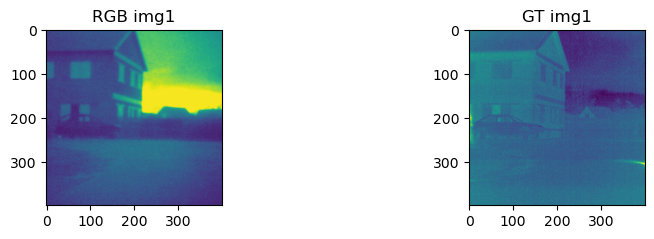

torch.Size([1, 400, 400])
torch.Size([1, 400, 400])
./origin_test_image/VIS/2.png
./origin_test_image/IR/2.png


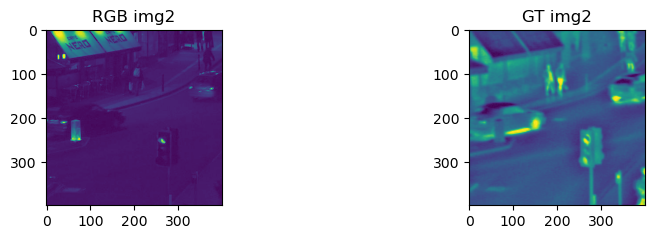

torch.Size([1, 400, 400])
torch.Size([1, 400, 400])
./origin_test_image/VIS/20.png
./origin_test_image/IR/20.png


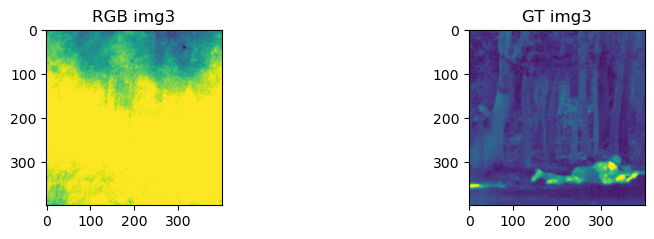

torch.Size([1, 400, 400])
torch.Size([1, 400, 400])
./origin_test_image/VIS/7.png
./origin_test_image/IR/7.png


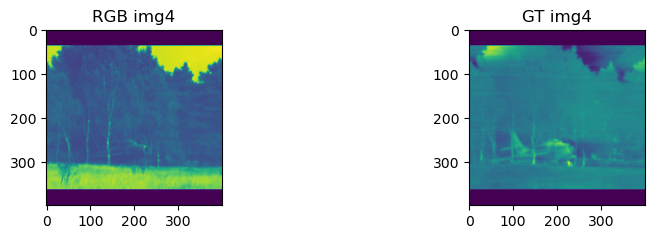

batch 2:
torch.Size([1, 400, 400])
torch.Size([1, 400, 400])
./origin_test_image/VIS/13.png
./origin_test_image/IR/13.png


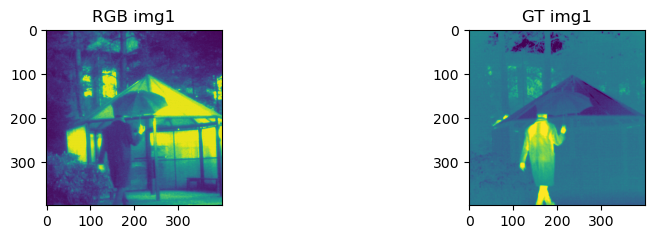

torch.Size([1, 400, 400])
torch.Size([1, 400, 400])
./origin_test_image/VIS/12.png
./origin_test_image/IR/12.png


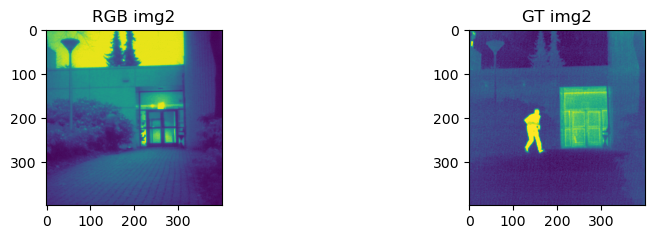

torch.Size([1, 400, 400])
torch.Size([1, 400, 400])
./origin_test_image/VIS/6.png
./origin_test_image/IR/6.png


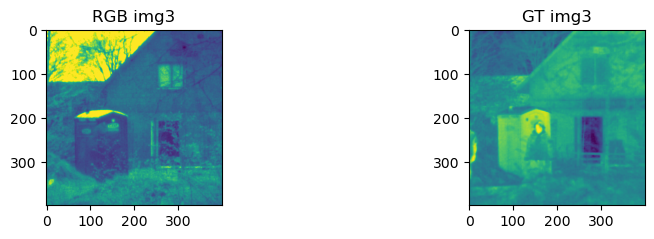

torch.Size([1, 400, 400])
torch.Size([1, 400, 400])
./origin_test_image/VIS/11.png
./origin_test_image/IR/11.png


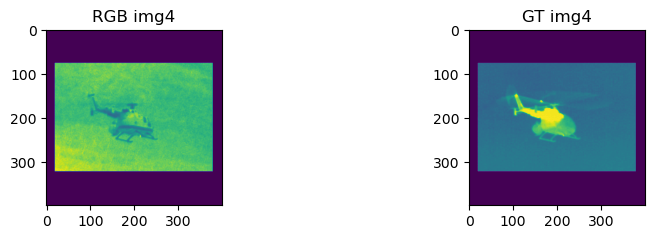

batch 3:
torch.Size([1, 400, 400])
torch.Size([1, 400, 400])
./origin_test_image/VIS/21.png
./origin_test_image/IR/21.png


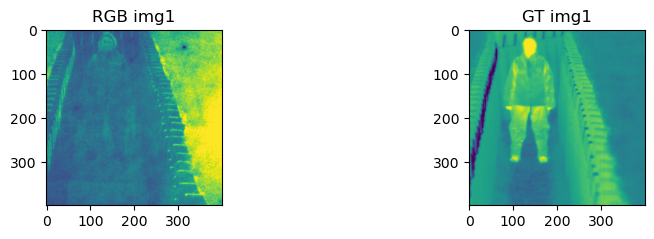

torch.Size([1, 400, 400])
torch.Size([1, 400, 400])
./origin_test_image/VIS/17.png
./origin_test_image/IR/17.png


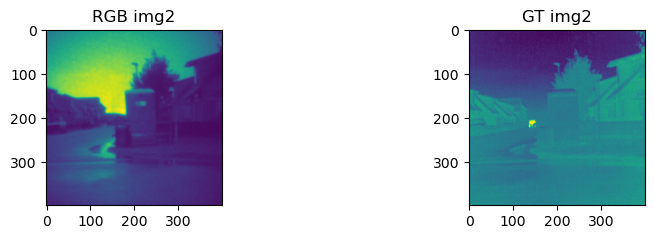

torch.Size([1, 400, 400])
torch.Size([1, 400, 400])
./origin_test_image/VIS/15.png
./origin_test_image/IR/15.png


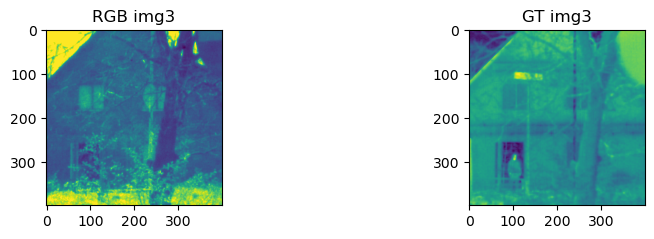

torch.Size([1, 400, 400])
torch.Size([1, 400, 400])
./origin_test_image/VIS/3.png
./origin_test_image/IR/3.png


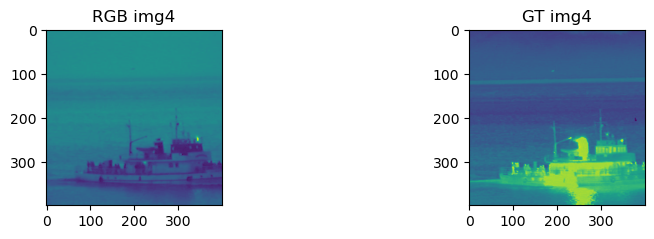

batch 4:
torch.Size([1, 400, 400])
torch.Size([1, 400, 400])
./origin_test_image/VIS/4.png
./origin_test_image/IR/4.png


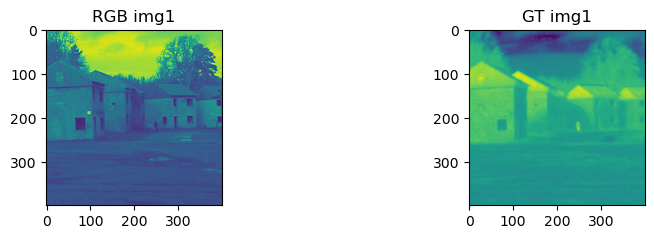

torch.Size([1, 400, 400])
torch.Size([1, 400, 400])
./origin_test_image/VIS/10.png
./origin_test_image/IR/10.png


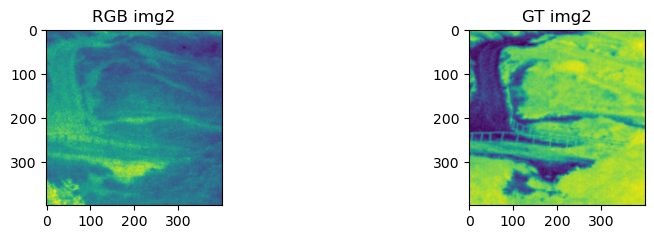

torch.Size([1, 400, 400])
torch.Size([1, 400, 400])
./origin_test_image/VIS/16.png
./origin_test_image/IR/16.png


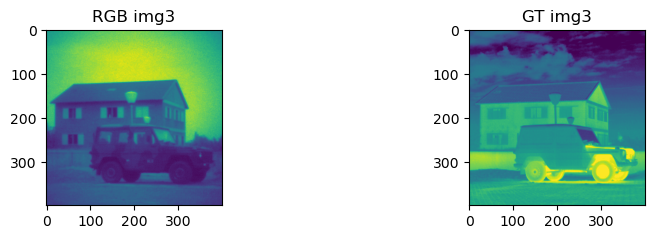

torch.Size([1, 400, 400])
torch.Size([1, 400, 400])
./origin_test_image/VIS/1.png
./origin_test_image/IR/1.png


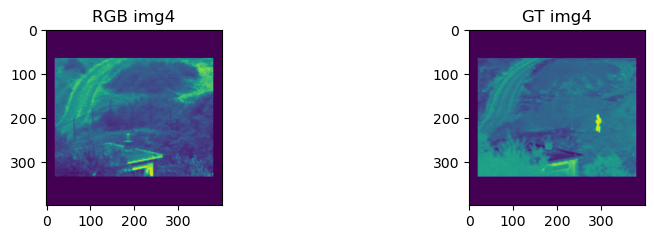

batch 5:
torch.Size([1, 400, 400])
torch.Size([1, 400, 400])
./origin_test_image/VIS/8.png
./origin_test_image/IR/8.png


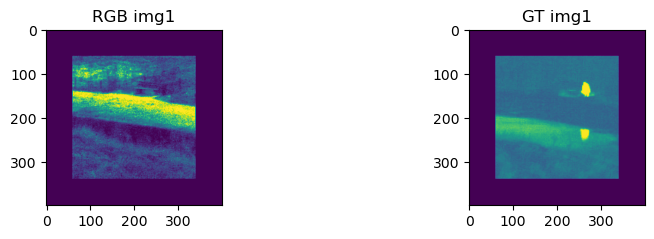

torch.Size([1, 400, 400])
torch.Size([1, 400, 400])
./origin_test_image/VIS/9.png
./origin_test_image/IR/9.png


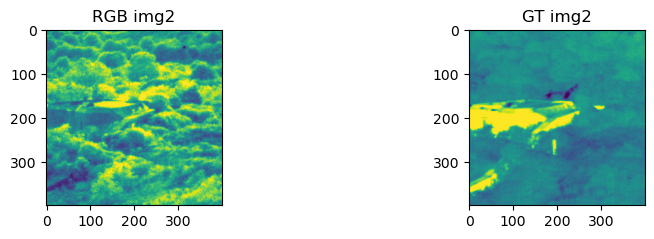

torch.Size([1, 400, 400])
torch.Size([1, 400, 400])
./origin_test_image/VIS/19.png
./origin_test_image/IR/19.png


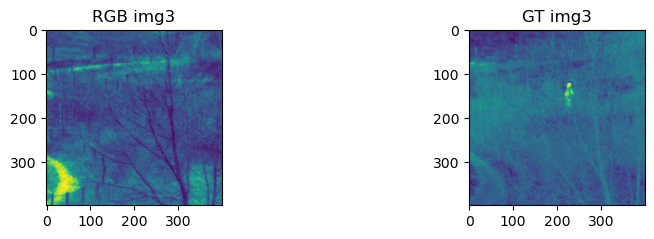

torch.Size([1, 400, 400])
torch.Size([1, 400, 400])
./origin_test_image/VIS/5.png
./origin_test_image/IR/5.png


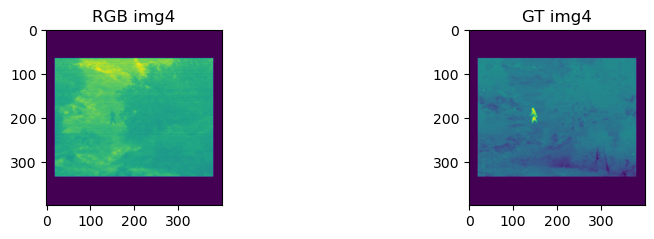

batch 6:
torch.Size([1, 400, 400])
torch.Size([1, 400, 400])
./origin_test_image/VIS/14.png
./origin_test_image/IR/14.png


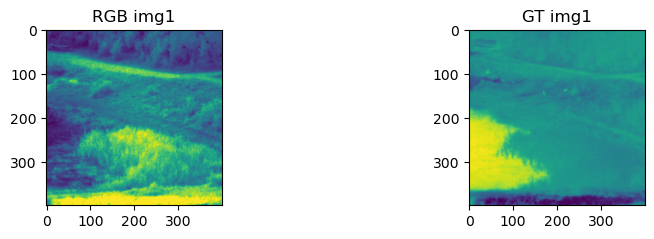

IndexError: index 1 is out of bounds for dimension 0 with size 1

In [6]:
from torch.utils.data import DataLoader

from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


bs=4 # batch size
# transforms = ToTensor()  # we need this to convert PIL images to Tensor
shuffle = True

dataset = CustomVisionDataset('./origin_test_image')
dataloader = DataLoader(dataset, batch_size=bs, shuffle=shuffle)

for i, (rgb, gt, rp, gtp) in enumerate(dataloader):
    print(f'batch {i+1}:')
    # some plots
    for i in range(bs):
        print(rgb[i].shape)
        print(gt[i].shape)
        print(rp[i])
        print(gtp[i])
        
        plt.figure(figsize=(10, 5))
        plt.subplot(221)
        plt.imshow(rgb[i].squeeze()[1:])
        plt.title(f'RGB img{i+1}')
        plt.subplot(222)
        plt.imshow(gt[i].squeeze()[1:])
        plt.title(f'GT img{i+1}')
        plt.show()